In [2]:
# import library
import re
import os 
import glob
import random
import numpy as np
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
%matplotlib inline
from pathlib import Path
from PIL import Image, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

import keras
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img
from keras.models import Model
from keras.layers import Dense, Dropout, Activation, Flatten, GlobalAveragePooling2D
from keras.layers import Conv2D, MaxPooling2D
from keras.optimizers import Adam, Nadam
from keras.applications import NASNetLarge
from keras import callbacks
from keras import optimizers, losses


In [8]:
# define base path
base_path = '/Users/jeffchan/Downloads/dataset_final/train/'

# check data classes
classes = os.listdir(base_path)
print(classes)

# count data
img_list = glob.glob(os.path.join(base_path, '*/*.jpg'))
print(len(img_list))

['paper', 'metal', 'cardboard', 'trash', 'glass', 'plastic']
6585


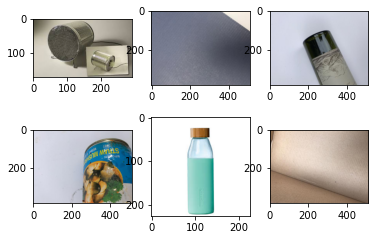

In [27]:
# plot some random image at random classes
for i, img_path in enumerate(random.sample(img_list, 6)):
    img = load_img(img_path)
    img = img_to_array(img, dtype=np.uint8)

    plt.subplot(2, 3, i+1)
    plt.imshow(img.squeeze())

In [61]:
# use ImageDataGenerator
train_datagen = ImageDataGenerator(rescale=1./255,
                                  width_shift_range=0.1,
                                  height_shift_range=0.1,
                                  shear_range=0.1,
                                  zoom_range=0.1,
                                  rotation_range=30,
                                  horizontal_flip=True,
                                  vertical_flip=True,
                                  preprocessing_function=vgg16.preprocess_input)

test_datagen = ImageDataGenerator(validation_split=0.2, preprocessing_function=vgg16.preprocess_input)

train_generator = train_datagen.flow_from_directory(base_path,
                                                   target_size=(331,331),
                                                   shuffle=True,
                                                   seed=42,
                                                   class_mode='categorical',
                                                   subset='training')

validation_generator = test_datagen.flow_from_directory(base_path,
                                                       target_size=(331,331),
                                                       shuffle=True,
                                                       seed=42,
                                                       class_mode='categorical',
                                                       subset='validation')

labels = train_generator.class_indices
# label the classes
labels = dict((v, k) for k, v in labels.items())
print(labels)

Found 4834 images belonging to 6 classes.
Found 966 images belonging to 6 classes.
{0: 'cardboard', 1: 'glass', 2: 'metal', 3: 'paper', 4: 'plastic', 5: 'trash'}


In [62]:
# Use VGG16 transfer learning to set our model
base_model = NASNetLarge(weights='imagenet', include_top=False, input_shape=(331, 331, 3))
x = base_model.output
x = Flatten()(x)
x = Dense(1024, activation='relu', kernel_initializer='he_uniform')(x)
x = Dropout(0.2)(x)
predictions = Dense(6, activation='softmax')(x)

# Define trainable model which links input from the  base model to the new classification prediction layers
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze layers in the vgg16 base model
for layer in base_model.layers[:-3]:
    layer.trainable = False

# Define model compile for basic Transfer Learning
model.compile(optimizer=Nadam(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

#define batch_size, epochs, steps_per_epoch, validation_steps
batch_size = 16
epochs = 50

print (model.summary())

343613440/343610240 [==============================] - 27s 0us/step
Model: "functional_17"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, 331, 331, 3) 0                                            
__________________________________________________________________________________________________
stem_conv1 (Conv2D)             (None, 165, 165, 96) 2592        input_9[0][0]                    
__________________________________________________________________________________________________
stem_bn1 (BatchNormalization)   (None, 165, 165, 96) 384         stem_conv1[0][0]                 
__________________________________________________________________________________________________
activation (Activation)         (None, 165, 165, 96) 0           stem_bn1[0][0]                   
__________________

In [34]:
# # build model
# model = Sequential()

# # 1st layer
# model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(224, 224, 3)))
# model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Dropout(0.2))

# # 2nd layer
# model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
# model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Dropout(0.2))

# # 3 layer
# model.add(Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
# model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Dropout(0.2))
# # 4 layer
# model.add(Conv2D(1024, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
# model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Dropout(0.2))

# # 5 layer
# model.add(Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
# model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Dropout(0.2))

# # output layer
# model.add(Flatten())
# model.add(Dense(256, activation='relu', kernel_initializer='he_uniform'))
# model.add(Dropout(0.5))
# model.add(Dense(6, activation='softmax'))

# # Define model compile for basic Transfer Learning
# model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [55]:
# set early stop
early_stop = callbacks.EarlyStopping(monitor='val_loss', patience=3)

In [ ]:
# fit model
history = model.fit_generator(train_generator,
                    epochs=epochs,
                    validation_data=validation_generator,
                    callbacks = [early_stop],
                    verbose=1)


Epoch 1/50
 19/152 [==>...........................] - ETA: 51:11 - loss: 3.4167 - accuracy: 0.5625

In [ ]:
# save best model
model.save(efficientb7_model.h5)
print('model saved')

In [57]:
# evaluate the model
score = model.evaluate_generator(validation_generator, verbose=1)
print('Test loss: ', score[0])
print('Test accuracy: ', score[1])

31/31 [==============================] - 39s 1s/step - loss: 22.9457 - accuracy: 0.2516


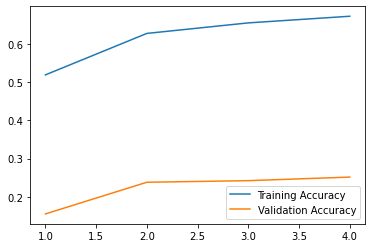

In [58]:
# plot data to see relationships in training and validation data
epoch_list = list(range(1, len(history.history['accuracy']) + 1))
plt.plot(epoch_list, history.history['accuracy'], epoch_list, history.history['val_accuracy'])
plt.legend(('Training Accuracy', 'Validation Accuracy'))
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

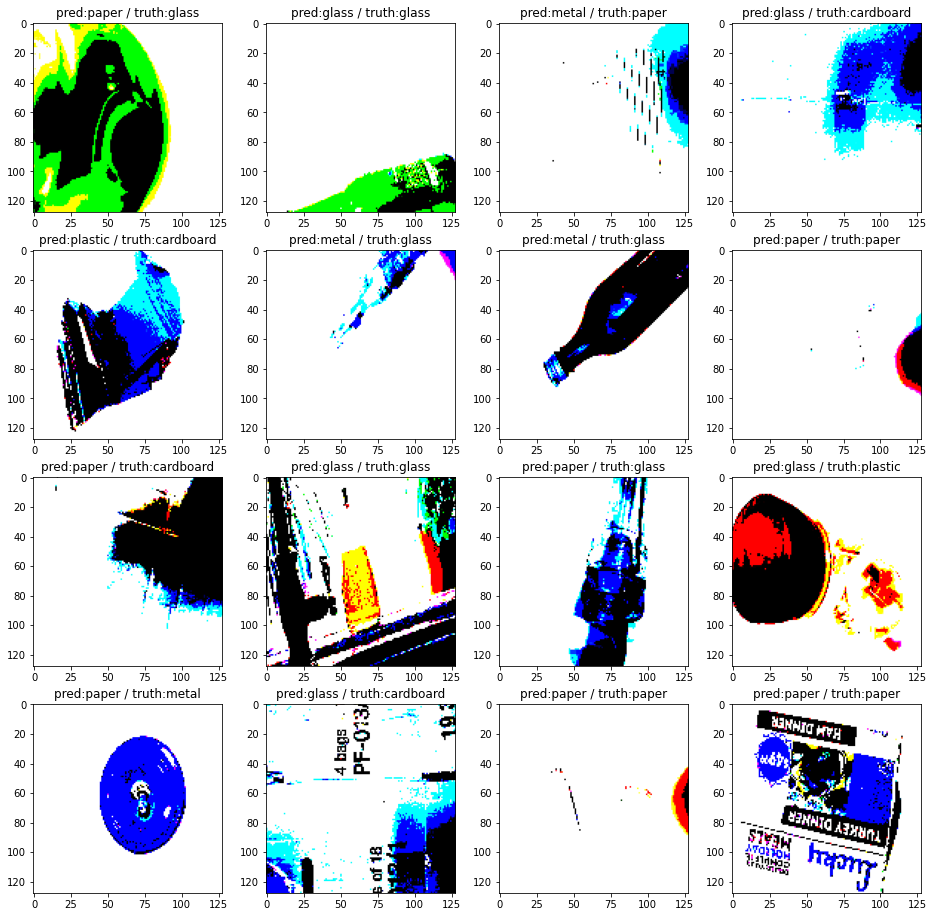

In [59]:
X_test, y_test = validation_generator.__getitem__(1)

preds = model.predict(X_test)
# Use 16 image make prediction
plt.figure(figsize=(16, 16))
for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.title('pred:%s / truth:%s' % (labels[np.argmax(preds[i])], labels[np.argmax(y_test[i])]))
    plt.imshow(X_test[i])